This notebook shows how I gather the information and track details of a few playlists from Spotify. The details are accessed using Spotipy which have wrapper functions for Spotify's RESTfuls API. The details are then used to analyze the difference between some of them. Prior to using Spotipy, remember to get the client id and client secret from Spotify Developer's Website.

In [22]:
# load dependencies
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

# get the credentials
credentials = json.load(open("authorization.json"))
client_id = credentials["client_id"]
client_secret = credentials["client_secret"]

# load the json file
playlist_index = 0  # the first playlist is a meditation music playlist
playlists = json.load(open("playlists_like_dislike.json"))

# Access the details

For each playlist, you could get the track details like the artists, ID's and the titles. Each track of have unique attributes called features. The features and description (from Spotify) for each track that are used for analysis later are:

- Danceability: 
    - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- Energy: 
    - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.  
- Loudness: 
    - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- Mode: 
    - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- Speechiness: 
    - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- Acousticness: 
    - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- Instrumentalness: 
    - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- Liveness: 
    - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- Valence: 
    - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- Tempo: 
    - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    
On top of that, Spotify also has a a number of audio attributes for each track, namely bars, beats, sections, tatum and segments. Tatums and beats provide the same information as bars, so they are not included here.

In [23]:
import numpy as np
import pandas as pd

# to set up Spotify obj
client_credentials_manager = SpotifyClientCredentials(client_id = client_id, client_secret=client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlist_tracks_id = []
playlist_tracks_titles = []
playlist_tracks_artists = []
playlist_tracks_first_artists = []
playlist_like_bool = []
playlist_purpose = []

num_bars = []
num_sections = []
num_segments = []

for j in range(len(playlists)):
#     print(j)
    playlist_index = j
    
    # get the first uri and like
    playlist_uri = playlists[playlist_index]["uri"]
    like = playlists[playlist_index]["like"]
    purpose = playlists[playlist_index]["purpose"]
    
    # the uri playlist_id 
    playlist_id = playlist_uri.split(":")[2]
    
    # get information of tracks
    results = spotify.playlist(playlist_id, "tracks")
    
    # get details of tracks
    playlist_tracks_data = results["tracks"]
    

    for item in playlist_tracks_data["items"]:
        playlist_tracks_id.append(item["track"]["id"])
        playlist_tracks_titles.append(item["track"]["name"])

        # there are multiple artists sometimes
        artist_list = []
        for sublist in item["track"]["artists"]:
            artist_list.append(sublist["name"])
        playlist_tracks_artists.append(artist_list)
        playlist_tracks_first_artists.append(artist_list[0])
        playlist_like_bool.append(like)
        playlist_purpose.append(purpose)

# get the features
features2 = []
for num in range(0,len(playlist_tracks_id), 50):
    ids = playlist_tracks_id[num:num+50]
    tmp = spotify.audio_features(ids)
    for tmp_dict in tmp:
        features2.append(tmp_dict)

# turn it into dataframe

features_df2 = pd.DataFrame(data = features2, columns=features2[0].keys())

# get the details
features_df2["Title"] = playlist_tracks_titles
features_df2["first_artist"] = playlist_tracks_first_artists
features_df2["all_artists"] = playlist_tracks_artists
features_df2["like"] = playlist_like_bool
features_df2["purpose"] = playlist_purpose

# get the features of interest
features_df2 = features_df2[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','id'
                       ,'Title', 'first_artist', 'all_artists', 'duration_ms', 'time_signature', 'like', 'purpose']]

# audio analysis
for i in range(len(features_df2["id"])):
    analysis = spotify.audio_analysis(features_df2.iloc[i]["id"])
    num_bars.append(len(analysis["bars"]))
    num_sections.append(len(analysis["sections"]))
    num_segments.append(len(analysis["segments"]))

# adding the extra information to the dataframe
features_df2["num_bars"] = num_bars
features_df2["num_sections"] = num_sections
features_df2["num_segments"] = num_segments

In [24]:
features_df2["purpose"].head()

0    meditation
1    meditation
2    meditation
3    meditation
4    meditation
Name: purpose, dtype: object

In [25]:
# save larger dataframe
features_df2.to_csv("large_playlist.csv",index="false")

# Comparing different playlist

For the purpose of analyzing the data, I'll analyze two playlists that I listen in different circumstances. One is a playlist for meditation and the other one is for when I am working out.

In [26]:
# getting a view of df
features_df2.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Title,first_artist,all_artists,duration_ms,time_signature,like,purpose,num_bars,num_sections,num_segments
0,0.163,0.0363,9,-28.038,1,0.0422,0.971,0.870,0.0937,0.0751,...,Changing Places,Leyton Miller,[Leyton Miller],176500,4,True,meditation,43,9,449
1,0.290,0.3320,10,-13.058,1,0.0302,0.539,0.967,0.1900,0.0374,...,Message from the Other Lands,Lama House,[Lama House],221413,4,True,meditation,45,10,537
2,0.326,0.2000,4,-20.150,0,0.0386,0.991,0.943,0.0867,0.4190,...,Nocturno,Henrietta Dubois,[Henrietta Dubois],129326,4,True,meditation,65,7,403
3,0.361,0.1220,2,-11.416,0,0.0364,0.983,0.820,0.0870,0.2770,...,Older,Lionheart,[Lionheart],188026,3,True,meditation,87,10,637
4,0.115,0.0664,1,-26.363,1,0.0405,0.958,0.924,0.0817,0.0380,...,Frangibility,Spheres,[Spheres],201000,4,True,meditation,107,11,655


In [28]:
# get the subset of data where the purpose is meditation or workout
interest = ["meditation", "workout"]
df = features_df2[features_df2["purpose"].isin(interest)]
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Title,first_artist,all_artists,duration_ms,time_signature,like,purpose,num_bars,num_sections,num_segments
0,0.163,0.0363,9,-28.038,1,0.0422,0.971,0.870,0.0937,0.0751,...,Changing Places,Leyton Miller,[Leyton Miller],176500,4,True,meditation,43,9,449
1,0.290,0.3320,10,-13.058,1,0.0302,0.539,0.967,0.1900,0.0374,...,Message from the Other Lands,Lama House,[Lama House],221413,4,True,meditation,45,10,537
2,0.326,0.2000,4,-20.150,0,0.0386,0.991,0.943,0.0867,0.4190,...,Nocturno,Henrietta Dubois,[Henrietta Dubois],129326,4,True,meditation,65,7,403
3,0.361,0.1220,2,-11.416,0,0.0364,0.983,0.820,0.0870,0.2770,...,Older,Lionheart,[Lionheart],188026,3,True,meditation,87,10,637
4,0.115,0.0664,1,-26.363,1,0.0405,0.958,0.924,0.0817,0.0380,...,Frangibility,Spheres,[Spheres],201000,4,True,meditation,107,11,655


In [31]:
# extracting the fetaures that we're interested in
variables = ['danceability', 'energy', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
# get the mean
mean_val = df[variables].mean().tolist()
mean_val

[0.4722355000000001,
 0.42974654999999984,
 -15.479840000000006,
 0.54,
 0.06976799999999998,
 0.4948865544999998,
 0.5242198526500004,
 0.144439,
 0.3871985,
 109.35112000000007]

We could see that loudness and tempo is not within 0-1, which will make graph a bit out of proportion, so we need to normalize them.

## Normalising loudness and tempo

In [34]:
# normalise
cols = ["loudness", "tempo"]
df[["loudness_norm", "tempo_norm"]] = df.groupby("purpose")[cols].apply(lambda x: (x-x.min())/(x.max()-x.min()))
df.head()

/home/han/.local/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,all_artists,duration_ms,time_signature,like,purpose,num_bars,num_sections,num_segments,loudness_norm,tempo_norm
0,0.163,0.0363,9,-28.038,1,0.0422,0.971,0.870,0.0937,0.0751,...,[Leyton Miller],176500,4,True,meditation,43,9,449,0.424107,0.078589
1,0.290,0.3320,10,-13.058,1,0.0302,0.539,0.967,0.1900,0.0374,...,[Lama House],221413,4,True,meditation,45,10,537,0.943111,0.000000
2,0.326,0.2000,4,-20.150,0,0.0386,0.991,0.943,0.0867,0.4190,...,[Henrietta Dubois],129326,4,True,meditation,65,7,403,0.697398,0.587196
3,0.361,0.1220,2,-11.416,0,0.0364,0.983,0.820,0.0870,0.2770,...,[Lionheart],188026,3,True,meditation,87,10,637,1.000000,0.282980
4,0.115,0.0664,1,-26.363,1,0.0405,0.958,0.924,0.0817,0.0380,...,[Spheres],201000,4,True,meditation,107,11,655,0.482140,0.852721


In [90]:
# separate df into meditation and workout
meditation = df[df["purpose"]=="meditation"]
workout = df[df["purpose"]=="workout"]
workout.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,all_artists,duration_ms,time_signature,like,purpose,num_bars,num_sections,num_segments,loudness_norm,tempo_norm
422,0.790,0.807,1,-5.560,1,0.140,0.064400,0.000030,0.3400,0.964,...,"[T-Pain, Teddy Verseti]",241773,4,False,workout,80,11,1147,0.734880,0.000457
423,0.883,0.878,1,-7.170,1,0.161,0.018700,0.133000,0.0351,0.659,...,"[Room 5, Oliver Cheatham]",212320,4,False,workout,108,8,984,0.617422,0.402370
424,0.828,0.855,9,-4.224,0,0.138,0.437000,0.000013,0.8330,0.566,...,"[DJ Zinc, Ms. Dynamite]",299012,4,False,workout,161,13,1328,0.832348,0.448129
425,0.671,0.840,9,-5.352,0,0.108,0.000608,0.636000,0.0691,0.221,...,"[Lenzman, IAMDDB]",314479,4,False,workout,226,15,1576,0.750055,0.842710
426,0.891,0.620,7,-7.463,1,0.244,0.139000,0.000016,0.0805,0.404,...,[Vybz Kartel],204500,4,False,workout,82,8,911,0.596046,0.162434


# Comparing workout and meditation playlists

Text(0.5, 1.05, 'Mean values of features for Meditation tracks vs Workout tracks')

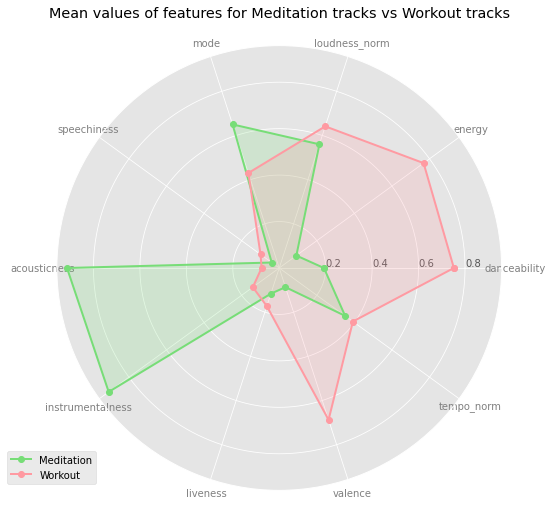

In [91]:
# load dependencies
import numpy as pi
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
plt.style.use("ggplot")

# number of variables 
variables = ['danceability', 'energy', 'loudness_norm', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_norm']
num_var = len(variables)

# extract the mean values from meditation and workout
meditation_means = meditation[variables].mean().tolist()
workout_means = workout[variables].mean().tolist()

# first value needs to be repeated
meditation_means += meditation_means[:1]
workout_means += workout_means[:1]

# angles of axis
from math import pi
angles = [n/float(num_var) * 2 * pi for n in range(num_var)]
angles += angles[:1]

# size of the plot
plt.figure(figsize=(18,18))
ax = plt.subplot(221, polar = True)

# labels
plt.xticks(angles[:-1], variables, color='grey')
ax.set_rlabel_position(0)


# meditation
ax.plot(angles, meditation_means, "o-", linewidth=2, label="Meditation", color = "#77DD77")
ax.fill(angles, meditation_means, "o-" ,alpha=0.2, facecolor = "#77DD77")

# workout
ax.plot(angles, workout_means, "o-", linewidth=2, label="Workout", color = "#FF9AA2")
ax.fill(angles, workout_means, "o-", alpha=0.2, facecolor="#FF9AA2")

# Legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

# 
plt.title("Mean values of features for Meditation tracks vs Workout tracks")

From the radar chart, it's clear to see that there are differences in different features between the two playlists. Meditation playlist scored quite high in acousticness and instrumentalness while workout playlist scored higher in energy, danceability, and valence. Workout playlist is slightly higher in speechiness, tempo, lineliness and loudness. 

I was surprised by the small differences in speechiness. Meditation tracks barely have any voice in it, if at all but workout tracks are all just songs. So, it turns out that high score in speechiness means that a track is composed mostly of spoken words, e.g. talk show, audio books. If both speech and music are present simultaneously, it'll have lower score than those of purely just spoken words.

Let's have a look at them in the form of bar chart.

## Bar chart

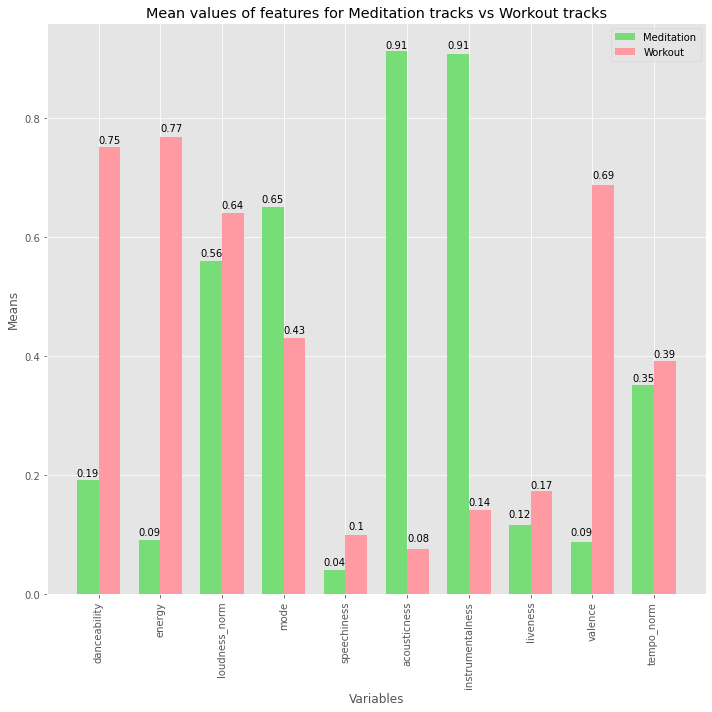

In [95]:
# load dependencies
import numpy as np

# number of variables 
variables = ['danceability', 'energy', 'loudness_norm', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_norm']
num_var = len(variables)
ind = np.arange(num_var)  # an array with the number of features

# initialise
width = 0.35
fig, ax = plt.subplots(figsize=(10,10))

# meditation
meditation_ax = ax.bar(ind - width/2, meditation_means[:-1], width, label="Meditation", color="#77DD77")

# workout
workout_ax = ax.bar(ind + width/2, workout_means[:-1], width, label="Workout", color = "#FF9AA2")

# labels
ax.set_ylabel("Means")
ax.set_xlabel("Variables")
ax.set_title("Mean values of features for Meditation tracks vs Workout tracks")
ax.legend()
ax.set_xticks(ind)
ax.set_xticklabels(variables, rotation=90)

# create a function to attach the label on top the bars
def autolabel(bars):
    for bar in bars:
        height = round(bar.get_height(),2)  # round the decimals 
        ax.annotate(f"{height}", xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), 
                    textcoords="offset points", ha="center", va="bottom")
        

autolabel(meditation_ax)
autolabel(workout_ax)

fig.tight_layout()

The bar chart provides an alternative view at the differences between the meditation and workout playlist. Meditation differs a lot from Workout in Acousticness, Instrumentalness, Danceability, Energy and Valence. Maybe we should test the differences using statistical test? Before that, let's look at the another bar chart to highlight the differences.

## Bar chart of differences

Text(0, 0.5, 'Differences')

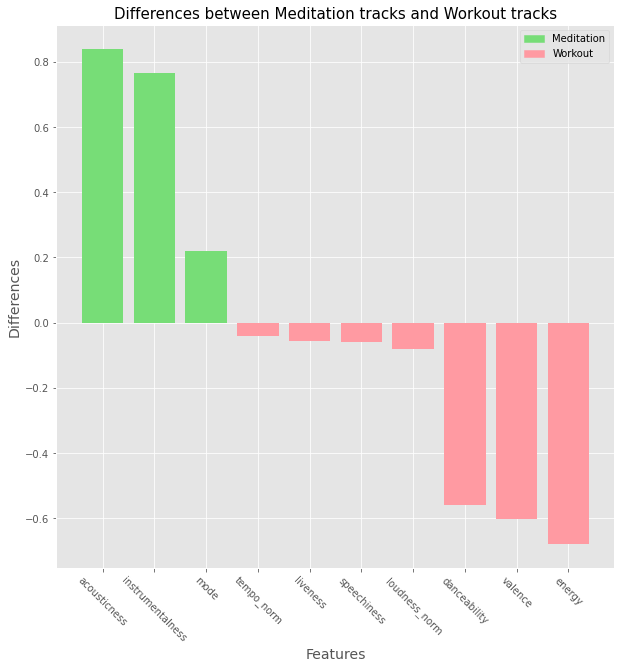

In [115]:
# differences
diff = meditation[variables].mean() - workout[variables].mean()
index_diff = diff.sort_values(ascending=False).index

# give them different colors
col = []
for val in diff.sort_values(ascending=False):
    if val > 0:
        col.append("#77DD77")
    else:
        col.append("#FF9AA2")

# bar chart
fig, ax = plt.subplots(figsize=(10,10))
xaxis = np.arange(diff.count())
yaxis = diff.sort_values(ascending=False)
plt.bar(xaxis, yaxis, color=col)
plt.xticks(xaxis)
ax.set_xticklabels(index_diff, rotation=-45)
ax.set_title("Differences between Meditation tracks and Workout tracks", fontsize=15)

# set the legend
import matplotlib.patches as patches
green = patches.Patch(color="#77DD77", label="Meditation")
red = patches.Patch(color="#FF9AA2", label="Workout")
plt.legend(handles=[green,red], loc="upper right")

# label 
plt.xlabel("Features", fontsize=14)
plt.ylabel("Differences", fontsize=14)

This barchart highlights the type of features that meditation and workout scored high in. Meditation scored highest in acousticness, instrumentalness and mode, whille workout tracks in everything else.

# Further analysis

Just out of curiosity, I wanted to test the differences between the two playlists on a few variables.

In [117]:
print(df.shape)  # df is the combined dataframe of meditation and workout
df.head()

(200, 24)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,all_artists,duration_ms,time_signature,like,purpose,num_bars,num_sections,num_segments,loudness_norm,tempo_norm
0,0.163,0.0363,9,-28.038,1,0.0422,0.971,0.870,0.0937,0.0751,...,[Leyton Miller],176500,4,True,meditation,43,9,449,0.424107,0.078589
1,0.290,0.3320,10,-13.058,1,0.0302,0.539,0.967,0.1900,0.0374,...,[Lama House],221413,4,True,meditation,45,10,537,0.943111,0.000000
2,0.326,0.2000,4,-20.150,0,0.0386,0.991,0.943,0.0867,0.4190,...,[Henrietta Dubois],129326,4,True,meditation,65,7,403,0.697398,0.587196
3,0.361,0.1220,2,-11.416,0,0.0364,0.983,0.820,0.0870,0.2770,...,[Lionheart],188026,3,True,meditation,87,10,637,1.000000,0.282980
4,0.115,0.0664,1,-26.363,1,0.0405,0.958,0.924,0.0817,0.0380,...,[Spheres],201000,4,True,meditation,107,11,655,0.482140,0.852721


In [121]:
# load libraries for statistics
# https://www.statisticssolutions.com/directory-of-statistical-analyses-manova-analysis/
from statsmodels.multivariate.manova import MANOVA
maov = MANOVA.from_formula("acousticness+instrumentalness+danceability+valence+energy~purpose", data=df)
maov.mv_test().summary()  # Wilk's lambda is used if homogeneity of variance is assumed

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Multivariate linear model
================================================================
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0184 5.0000 194.0000 2065.6616 0.0000
         Pillai's trace  0.9816 5.0000 194.0000 2065.6616 0.0000
 Hotelling-Lawley trace 53.2387 5.0000 194.0000 2065.6616 0.0000
    Roy's greatest root 53.2387 5.0000 194.0000 2065.6616 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
        purpose          Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0239 5.0000 194.0000 1581.4236 0.0000
         Pillai's trace  0.9761 5.0000 194.0000 1581.4236 0.0000
 Hotelling-Lawley trace 40.7583 5.0000 194.0000 1581.4236 0.0000
    Roy's greatest root 40.7583 5.0000 194.0000 1581.4236 0.0000
================================================================

"""

## Test the homogeneity of variances

In [135]:
# test the homoegeneity of variances
from scipy.stats import levene
from scipy import stats
variables = ['danceability', 'energy', 'loudness_norm', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_norm']
levenes = []
for item in variables:
    stat, p = levene(meditation[item], workout[item])
    print(f"P-value for {item} is {p}")
    levenes.append(p)
# only danceability, mode, acousticness have homogeneity of variance

P-value for danceability is 0.15830543039791434
P-value for energy is 7.441611771653328e-08
P-value for loudness_norm is 0.001125588570897434
P-value for mode is 0.2483108624735683
P-value for speechiness is 5.141441990776434e-13
P-value for acousticness is 0.7678447194191613
P-value for instrumentalness is 9.360981054497347e-05
P-value for liveness is 1.6309322562796069e-06
P-value for valence is 4.560496752765803e-17
P-value for tempo_norm is 0.0012969672697613766


## Test for normality

In [136]:
# test for normality using Shapiro-Wilk's test
# if smaller than alpha = 0.05, it's not normally distributed
for item in variables:
    stat1, p1 = stats.shapiro(meditation[item])
    stat2, p2 = stats.shapiro(workout[item])
    if p1>0.05 or p2>0.05:
        print(f"Meditation's {item} p-value is {p1}; Workout's {item} p-value is {p2}")
# only loudness is normally distributed
# However, ttest is valid for large samples, ie N > 30
# https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50

Meditation's loudness_norm p-value is 0.1610034555196762; Workout's loudness_norm p-value is 0.07804235816001892


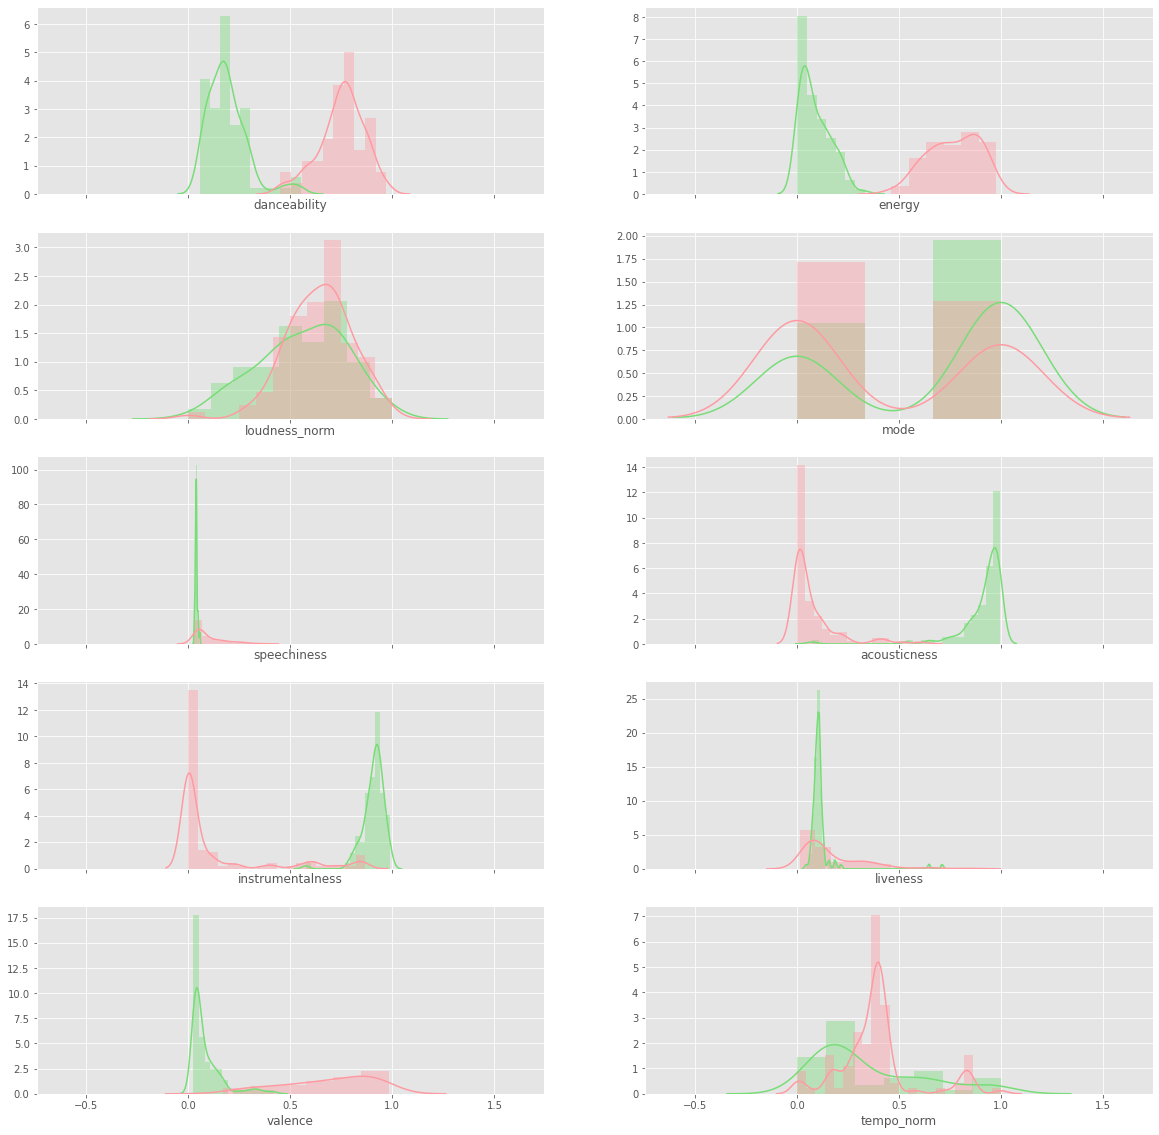

In [146]:
# plot the distributions
f, axes = plt.subplots(5,2, figsize=(20,20), sharex=True)
for ax, feature in zip(axes.flat, variables):
    sb.distplot(meditation[feature], color="#77DD77", ax=ax)
    sb.distplot(workout[feature], color="#FF9AA2", ax=ax)

The graphs show that the distribution for the data are far from normal. As per Shapiro-Wilk's test shown, loudness is probably the only variable that showed somewhat normal distribution. Mode has a bimodal distribution and is, therefore, not a continuous variable. Thus, mode should be dropped. Given that the normality appears to be violated, I've decided to use non-parametric tests to test the differences. I was thinking of Wilcoxon's test but Wilcoxon has a requirement that the distribution is symmmetry, i.e. not skewed. The distributions of the variables are quite obviously skewed, however. Let's try to transform the data.

In [147]:
# remove variables from testing
variables.remove("mode")
variables

['danceability',
 'energy',
 'loudness_norm',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo_norm']

## Correlation matrix between the variables

Just out of curiosity, I decided to test the correlation between the variables in a single group. 

### Correlation between variables in meditation df

Text(0.5, 1.0, 'Correlation matrix for variables in Mediation df')

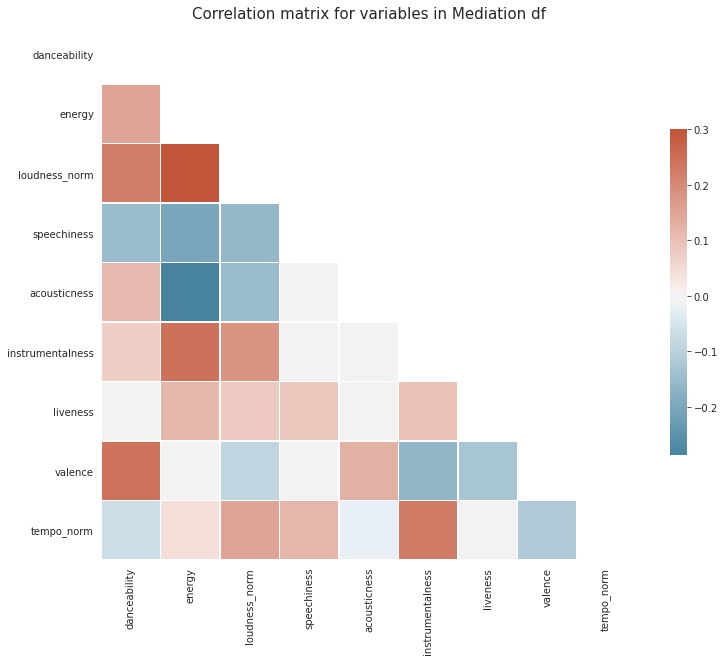

In [229]:
med_df = meditation[variables]
sb.set_style(style="white")

# compute correlation
corr = med_df.corr()

# generate mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set the fig
fig, ax = plt.subplots(figsize=(12,12))

# generate a custom diverging colormap
cmap = sb.diverging_palette(230,20, as_cmap=True)

# draw the heatmap
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation matrix for variables in Mediation df", fontsize=15)

### Correlation between variables in workout df

Text(0.5, 1.0, 'Correlation matrix for variables in Workout df')

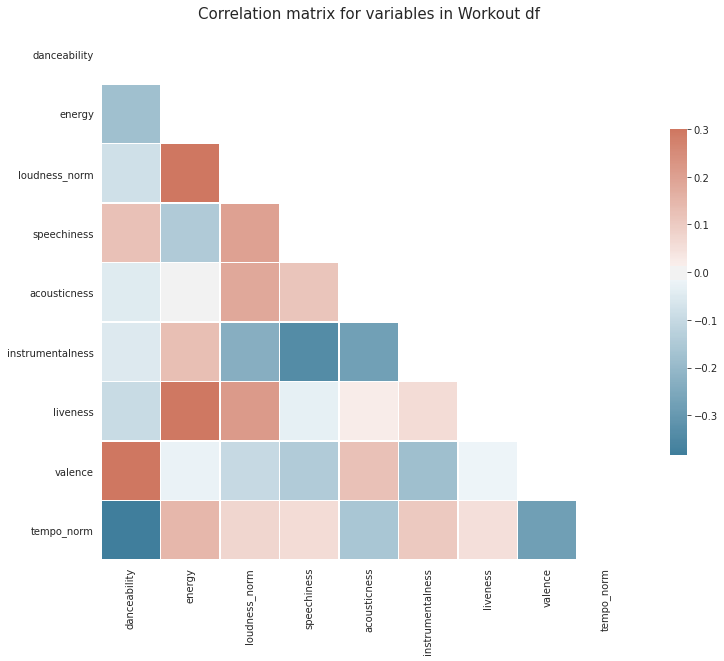

In [230]:
workout_df = workout[variables]
sb.set_style(style="white")

# compute correlation
corr = workout_df.corr()

# generate mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set the fig
fig, ax = plt.subplots(figsize=(12,12))

# generate a custom diverging colormap
cmap = sb.diverging_palette(230,20, as_cmap=True)

# draw the heatmap
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation matrix for variables in Workout df", fontsize=15)

From the results, we could see that the variables within each group are weakly correlated with one another. In other words, independence of variables could be assumed. Note that this is not the same as testing for correlation between "Energy" of meditation playlist and that of workout playlist. For that, we could asssume independence as the tracks are not related by any means.

## Transformation

In [168]:
meditation[variables].head()

,danceability,energy,loudness_norm,speechiness,acousticness,instrumentalness,liveness,valence,tempo_norm
0,0.163,0.0363,0.424107,0.0422,0.971,0.870,0.0937,0.0751,0.078589
1,0.290,0.3320,0.943111,0.0302,0.539,0.967,0.1900,0.0374,0.000000
2,0.326,0.2000,0.697398,0.0386,0.991,0.943,0.0867,0.4190,0.587196
3,0.361,0.1220,1.000000,0.0364,0.983,0.820,0.0870,0.2770,0.282980
4,0.115,0.0664,0.482140,0.0405,0.958,0.924,0.0817,0.0380,0.852721


### Normalising using MinMaxScaler from sklearn

In [195]:
# normalising the meditation dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

med_df = meditation[variables]
med_scaled = med_df.copy()
med_scaled[variables] = scaler.fit_transform(med_df[variables])
med_scaled.head()

,danceability,energy,loudness_norm,speechiness,acousticness,instrumentalness,liveness,valence,tempo_norm
0,0.210740,0.103749,0.424107,0.458904,0.972894,0.710843,0.072874,0.128705,0.078589
1,0.469081,1.000000,0.943111,0.047945,0.504500,0.944578,0.217274,0.033190,0.000000
2,0.542311,0.599915,0.697398,0.335616,0.994579,0.886747,0.062378,1.000000,0.587196
3,0.613507,0.363501,1.000000,0.260274,0.985905,0.590361,0.062828,0.640233,0.282980
4,0.113100,0.194981,0.482140,0.400685,0.958799,0.840964,0.054881,0.034710,0.852721


In [194]:
stats.normaltest(med_scaled)

NormaltestResult(statistic=array([ 36.63906126,  10.30215327,   3.23021996,  18.77401964,
       123.64169862,  77.39162624, 158.88570996,  61.20807121,
        14.76549948]), pvalue=array([1.10644272e-08, 5.79316425e-03, 1.98868798e-01, 8.38056759e-05,
       1.41757576e-27, 1.56538760e-17, 3.15069567e-35, 5.11488900e-14,
       6.21888502e-04]))

In [196]:
## normalising the workout dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

workout_df = workout[variables]
workout_scaled = workout_df.copy()
workout_scaled[variables] = scaler.fit_transform(workout_df[variables])
workout_scaled.head()

,danceability,energy,loudness_norm,speechiness,acousticness,instrumentalness,liveness,valence,tempo_norm
422,0.652510,0.669261,0.734880,0.332729,0.104700,0.000035,0.396203,0.976658,0.000457
423,0.832046,0.807393,0.617422,0.396135,0.030389,0.153226,0.022780,0.601966,0.402370
424,0.725869,0.762646,0.832348,0.326691,0.710564,0.000015,1.000000,0.487715,0.448129
425,0.422780,0.733463,0.750055,0.236111,0.000971,0.732719,0.064421,0.063882,0.842710
426,0.847490,0.305447,0.596046,0.646739,0.226003,0.000019,0.078383,0.288698,0.162434


In [197]:
stats.normaltest(workout_scaled)

NormaltestResult(statistic=array([ 5.8098137 ,  8.73782103, 10.19498071, 29.6148905 , 70.02811051,
       38.46673689, 45.53130068, 10.69729947, 19.8319904 ]), pvalue=array([5.47538906e-02, 1.26650314e-02, 6.11206646e-03, 3.70858499e-07,
       6.21711662e-16, 4.43664026e-09, 1.29719026e-10, 4.75456658e-03,
       4.93785124e-05]))

The results are still not satisfactory even after normalising them using minmaxscaler.

### Log transformation

In [201]:
# log transform meditation df
import numpy as np
med_df = meditation[variables]
for c in med_df.select_dtypes(include = [np.number]).columns:
    med_df[c] = np.log10(med_df[c]+1)  # +1 because log of 0 will be inf
med_df.head()

/home/han/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,danceability,energy,loudness_norm,speechiness,acousticness,instrumentalness,liveness,valence,tempo_norm
0,0.065580,0.015485,0.153543,0.017951,0.294687,0.271842,0.038898,0.031449,0.032856
1,0.110590,0.124504,0.288498,0.012922,0.187239,0.293804,0.075547,0.015946,0.000000
2,0.122544,0.079181,0.229784,0.016448,0.299071,0.288473,0.036110,0.151982,0.200630
3,0.133858,0.049993,0.301030,0.015527,0.297323,0.260071,0.036230,0.106191,0.108220
4,0.047275,0.027920,0.170889,0.017242,0.291813,0.284205,0.034107,0.016197,0.267810


In [202]:
# log transform workout df
workout_df = workout[variables]
for c in workout_df.select_dtypes(include = [np.number]).columns:
    workout_df[c] = np.log10(workout_df[c]+1)  # +1 because log of 0 will be inf
workout_df.head()

/home/han/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,danceability,energy,loudness_norm,speechiness,acousticness,instrumentalness,liveness,valence,tempo_norm
422,0.252853,0.256958,0.239269,0.056905,0.027105,0.000013,0.127105,0.293141,0.000198
423,0.274850,0.273696,0.208823,0.064832,0.008046,0.054230,0.014982,0.219846,0.146862
424,0.261976,0.268344,0.263008,0.056142,0.157457,0.000006,0.263162,0.194792,0.160807
425,0.222976,0.264818,0.243052,0.044540,0.000264,0.213783,0.029018,0.086716,0.265457
426,0.276692,0.209515,0.203045,0.094820,0.056524,0.000007,0.033625,0.147367,0.065368


## Reassess log transformed data for normality

In [205]:
# if smaller than alpha = 0.05, it's not normally distributed
for item in variables:
    stat1, p1 = stats.shapiro(med_df[item])
    stat2, p2 = stats.shapiro(workout_df[item])
    if p1>0.05 or p2>0.05:
        print(f"Meditation's {item} p-value is {p1}; Workout's {item} p-value is {p2}")
# log transformation does not make it better

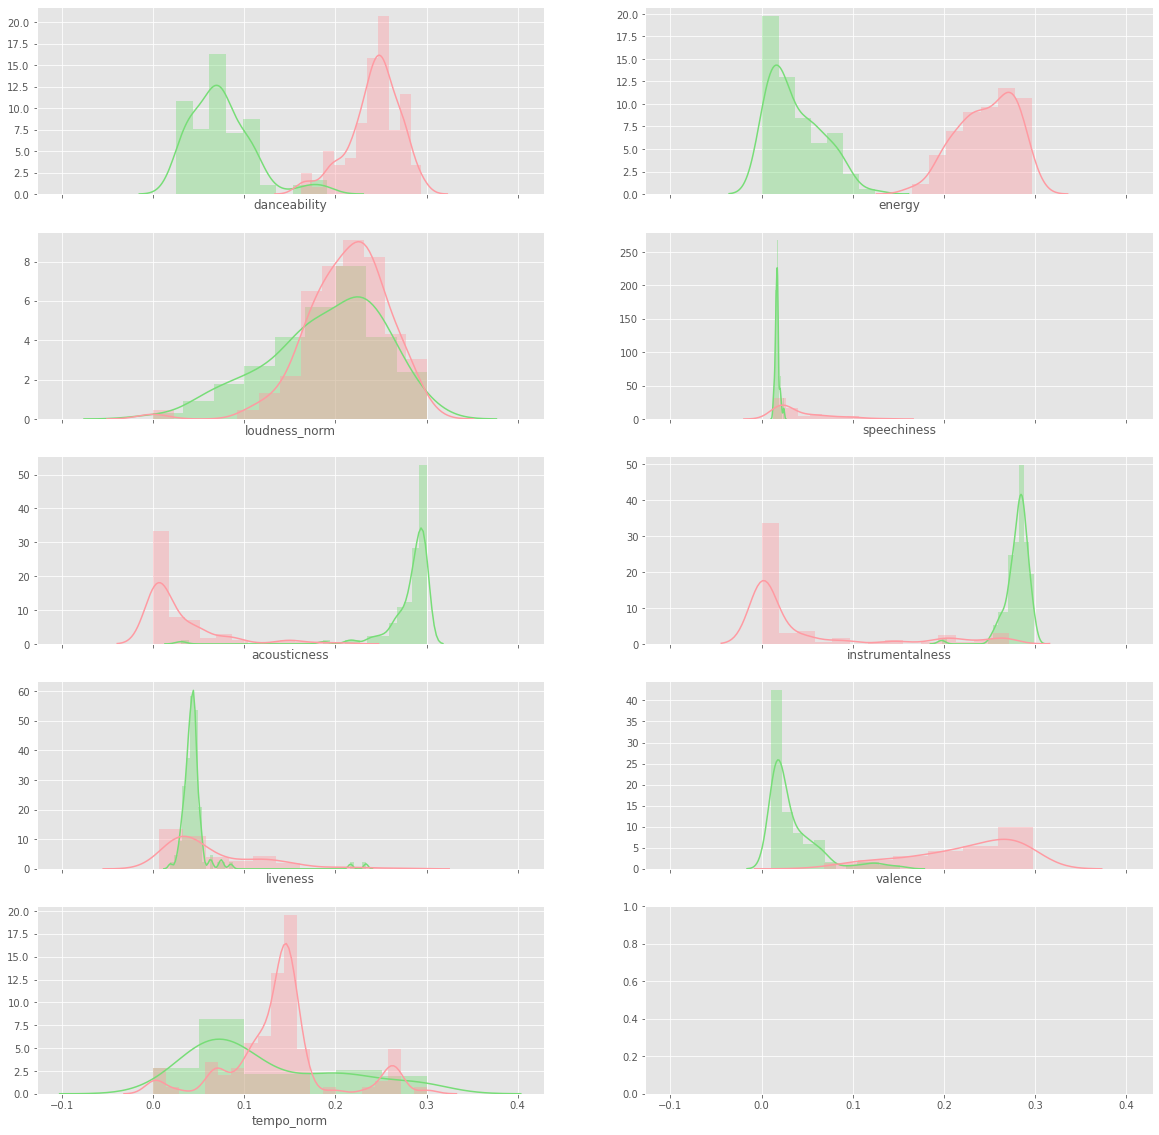

In [206]:
# plot the distributions of transformed data
f, axes = plt.subplots(5,2, figsize=(20,20), sharex=True)
for ax, feature in zip(axes.flat, variables):
    sb.distplot(med_df[feature], color="#77DD77", ax=ax)
    sb.distplot(workout_df[feature], color="#FF9AA2", ax=ax)

## Box cox transformation

In [215]:
from scipy import stats
import numpy as np
med_df = meditation[variables]
for c in med_df.select_dtypes(include = [np.number]).columns:
    med_df[c] = stats.boxcox(med_df[c]+1)[0]  # +1 because 0 will return error
med_df.head()

/home/han/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,danceability,energy,loudness_norm,speechiness,acousticness,instrumentalness,liveness,valence,tempo_norm
0,0.107024,0.032123,0.500122,0.018299,4004.657002,830.810723,0.049166,0.044256,0.068458
1,0.146150,0.137401,1.312274,0.016072,70.183459,1780.694370,0.061563,0.028265,0.000000
2,0.153634,0.111185,0.900912,0.017754,4723.042173,1479.849755,0.047417,0.066609,0.264574
3,0.159853,0.083298,1.414298,0.017375,4422.277572,552.152590,0.047496,0.065230,0.181627
4,0.084554,0.053406,0.580166,0.018053,3594.161022,1276.092845,0.046052,0.028597,0.301140


In [216]:
stats.normaltest(med_df)
# not all variables have become normally distributed
# boxcox won't be conducted on the workout_df since we won't be able to use them.

NormaltestResult(statistic=array([ 1.02464611, 31.94434202,  2.73251196,  1.4962893 , 10.42169918,
        0.07541734, 11.34953711, 32.33240318, 14.84484803]), pvalue=array([5.99102215e-01, 1.15710899e-07, 2.55060124e-01, 4.73243771e-01,
       5.45703547e-03, 9.62993447e-01, 3.43146308e-03, 9.53032820e-08,
       5.97698557e-04]))

Given that the normality of the dataset prior to transformation does is not normally distributed and there's no homogeneity of variance, this means that a parametric tests which normally has the assumption of normally distributed data could not be used. Even after different transformation, the distribution still isn't satisfactory. So, I've decided not to transform the data and try non-parametric tests instead. Wilcoxon's signed-rank test is a non-parametric test. However, it is sensitive to non-symmetrical data and so, it's not used. 

# Sign test

Sign test, short for paired-samples sign test, is a non-parametric test used to detect the difference in medians between paired or matched observations. It is normally used to test same cohort of participants in two conditions or time. However, two different samples are considered as "matched-pair". Furthermore, because I'm going to conduct multiple test, there's a possibility of inflating Type I error. In order to reduce it, I decided to use Bonferroni's correction. The alpha level is set to original alpha level (0.05) divided by number of test. 
More information on sign test: https://statistics.laerd.com/spss-tutorials/sign-test-using-spss-statistics.php. More information on the Bonferroni adjustment: https://www.statsandr.com/blog/how-to-do-a-t-test-or-anova-for-many-variables-at-once-in-r-and-communicate-the-results-in-a-better-way/

In [233]:
from statsmodels.stats import descriptivestats
med_df = meditation[variables]
workout_df = workout[variables]
alpha = 0.05/len(variables)
for i, item in enumerate(variables):
    stats, p = descriptivestats.sign_test(med_df[item], workout_df[item])
    if p < alpha:  # Bonferroni correction
        print(f"Difference in {item.capitalize()} is significant (p={p}).")

Difference in Danceability is significant (p=1.5777218104420236e-30).
Difference in Energy is significant (p=1.5777218104420236e-30).
Difference in Loudness_norm is significant (p=0.00239462935750601).
Difference in Speechiness is significant (p=1.911357536027706e-15).
Difference in Acousticness is significant (p=1.5777218104420236e-30).
Difference in Instrumentalness is significant (p=1.5934990285464443e-28).
Difference in Valence is significant (p=7.969072864542664e-27).


# Conclusion

This has been a fun project to do! A brief recap, I've selected a few playlist from Spotify. From these selections, I've picked Meditation and Workout playlist to analyze them. Spotify have different features for each track like energy, acousticness, etc. I analyze the differences between the two playlist using graphical means. Then, I tested some assumptions of the data in order to decide which statistical test to use in order to quantifiably test the differences. The datasets weren't normally distributed so I tried to transform the data using a few methods. None of them gave any satifying results. Therefore, I resorted to non-parametric test instead, specifically sign test. The test shows that the two playlist are different in terms of Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness and Valence. The data science-y part might be done for now but there's a few steps that I'm thinking of taking this project to. If you have any idea, let me know!